# Emittance Sample study


# Imports

In [1]:
# Ignore all warnings
import warnings
# warnings.filterwarnings("ignore")

import sys
# sys.path.append('C:\\Users\\Dylan\\SLAC') #parent directory containing emitopt module

import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

from emitopt.analysis import compute_emit_bmag
from emitopt.sampling import draw_product_kernel_post_paths
from emitopt.algorithms import GridMinimizeEmitBmag

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
if torch.cuda.is_available():
# if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    tkwargs = {"dtype": torch.double, "device": "cuda"}
    use_cuda = True
    print('Using cuda.')
else:
    torch.set_default_tensor_type('torch.DoubleTensor')
    use_cuda = False

C:\Users\Dylan\AppData\Roaming\Python\Python39\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [3]:
torch.cuda.is_available()

False

# Notebook settings

In [4]:
ndim = 4 #number of input dimensions
noise = False #whether to add noise to the ground-truth beam size function outputs
thick_quad = True
meas_dim = 1 #input dimension for measurement parameter
n_obs_init = 50 #number of random initial observations for GP model
n_samples = 10 #number of posterior samples for BAX
n_iter = 1 #number of optimization steps for Xopt to take (after acquiring random initial data)
rand_seed = 3

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [5]:
from pyemittance.emittance_calc import EmitCalc
from pyemittance.load_json_configs import load_configs
from pyemittance.simulation import BeamSim

CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']

q_len = CONFIG['beamline_info']['Lquad']
rmat_x = torch.tensor(CONFIG['beamline_info']['rMatx']).reshape(2,2)
rmat_y = torch.tensor(CONFIG['beamline_info']['rMaty']).reshape(2,2)
print(rmat_x)
print(rmat_y)

tensor([[1.0000, 2.2000],
        [0.0000, 1.0000]])
tensor([[1.0000, 2.2000],
        [0.0000, 1.0000]])


In [6]:
BUNCH_PARAMS0 = {
    'total_charge': 50e-12,
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}
sim = BeamSim(bunch_params=BUNCH_PARAMS0, beamline_info=CONFIG['beamline_info'])


# define variables functions
var_names = ['x' + str(i) for i in range(ndim)]
meas_param = var_names[meas_dim]

scale = 1.e3
def measure_beamsize(input_dict):
    x_tuning = torch.tensor([])
    for key in input_dict.keys():
        if key is not meas_param:
            x_tuning = torch.cat((x_tuning, torch.tensor([input_dict[key]])))
    rms_beamsizes0 = np.array(sim.beam_size_meas(input_dict[meas_param]))
    detuning_scale = 1. + 1*x_tuning.abs().sum().cpu()
    xrms, yrms = detuning_scale * rms_beamsizes0
    return {'xrms_sq': (float(xrms)*scale)**2.,
            'yrms_sq': (float(yrms)*scale)**2.} # mean-square beam sizes in mm squared

from emitopt.utils import get_quad_scale_factor
scale_factor = get_quad_scale_factor(E=.08, q_len=q_len)
# scale_factor = 1.
q = torch.linspace(-3,3,11)
bs = torch.tensor([np.array(sim.beam_size_meas(v))*scale for v in q.numpy()]).T
print(bs)
k = scale_factor*q
ks = torch.stack((k,-k))
rmats = torch.stack((rmat_x, rmat_y))
emit, bmag, sig, is_valid = compute_emit_bmag(ks, bs**2, q_len, rmats, thick=True)
print(emit[0], emit[1])
gt_emit_min = (emit[0]*emit[1]).sqrt()
def ground_truth_geometric_mean_emittance(emit_min, x_tuning):
    detuning_scale = 1. + x_tuning.abs().sum(dim=1)
    emit = emit_min * detuning_scale**2
    return emit

print('Ground truth minimum emit:', gt_emit_min)

tensor([[0.9752, 0.8407, 0.7075, 0.5757, 0.4454, 0.3170, 0.1917, 0.0794, 0.0909,
         0.2042, 0.3252],
        [0.4155, 0.2362, 0.0847, 0.1697, 0.3502, 0.5391, 0.7314, 0.9260, 1.1227,
         1.3214, 1.5219]])
tensor(0.0064) tensor(0.0128)
Ground truth minimum emit: tensor(0.0090)


C:\Users\Dylan\AppData\Local\Temp\ipykernel_14820\3546267113.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  bs = torch.tensor([np.array(sim.beam_size_meas(v))*scale for v in q.numpy()]).T


# Construct vocs

In [7]:
variables = {var_name: [-2,1] for var_name in var_names}
variables[meas_param] = [-3,3] #overwrite bounds for measurement parameter to capture minimum of single-quadrupole optical model

#construct vocs
vocs = VOCS(
    variables = variables,
    observables = ['xrms_sq', 'yrms_sq'],
)

print('variable_names =', vocs.variable_names)
print('meas_param =', "'" + meas_param + "'")
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1', 'x2', 'x3']
meas_param = 'x1'
domain =
 [[-2.  1.]
 [-3.  3.]
 [-2.  1.]
 [-2.  1.]]


# Prepare generator options.
In this example, we use a specialty covariance module (Matern x Quadratic kernel) for our beam size model.

In [8]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator
from emitopt.algorithms import ScipyMinimizeEmittanceXY

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(meas_dim)
covar_module_x = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )

scaled_covar_module_x = ScaleKernel(covar_module_x)#, outputscale_prior=GammaPrior(2.0, 0.15))
covar_module_y = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module_y =  ScaleKernel(covar_module_y)#, outputscale_prior=GammaPrior(2.0, 0.15))

# prepare options for Xopt generator
covar_module_dict = {'xrms_sq': scaled_covar_module_x,
                     'yrms_sq': scaled_covar_module_y}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

In [9]:
from xopt.numerical_optimizer import LBFGSOptimizer, GridOptimizer
numerical_optimizer = LBFGSOptimizer(
                                    n_restarts=20,
                                    max_time=2)
# numerical_optimizer = GridOptimizer()

# Construct generator, evaluator, Xopt objects

In [10]:
# class DifferentialEvolutionEmitBmag(GridMinimizeEmitBmag):
#     name = "DifferentialEvolutionEmitBmag"

#     def get_execution_paths(self, model: ModelList, bounds: Tensor, tkwargs=None, verbose=False):
#         if not (self.x_key or self.y_key):
#             raise ValueError("must provide a key for x, y, or both.")
#         if (self.x_key and self.rmat_x is None) or (self.y_key and self.rmat_y is None):
#             raise ValueError("must provide rmat for each transverse dimension (x/y) being modeled.")
    
#         tkwargs = tkwargs if tkwargs else {"dtype": torch.double, "device": "cpu"}

#         temp_id = self.meas_dim + 1
#         tuning_domain = torch.cat((bounds.T[: self.meas_dim], bounds.T[temp_id:]))

#         tuning_bounds = tuning_domain.T
        
#         cpu_models = [copy.deepcopy(m).cpu() for m in model.models]

#         sample_funcs_list = []
#         for cpu_model in cpu_models:
#             if type(cpu_model.covar_module.base_kernel) == ProductKernel:
#                 sample_funcs = draw_product_kernel_post_paths(cpu_model, n_samples=self.n_samples)
#             if type(cpu_model.covar_module.base_kernel) == MaternKernel:
#                 sample_funcs = draw_matheron_paths(cpu_model, sample_shape=torch.Size([self.n_samples]))
#             sample_funcs_list += [sample_funcs]
        
        

In [11]:
#Prepare Algorithm
algo_kwargs = {
        'x_key': 'xrms_sq',
        'y_key': 'yrms_sq',
        'scale_factor': scale_factor,
        'q_len': q_len,
        'rmat_x': rmat_x,
        'rmat_y': rmat_y,
        'twiss0_x': torch.tensor([10., -1.]),
        'twiss0_y': torch.tensor([11., -2.]),
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 7,
        'thick_quad': thick_quad,
        'n_grid_points': 15
}
algo = GridMinimizeEmitBmag(**algo_kwargs)
# algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         gp_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo, 
                         use_cuda=use_cuda)

#construct evaluator
evaluator = Evaluator(function=measure_beamsize)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

# Optimize

In [12]:
# call X.random_evaluate() to generate random initial points and evaluate on test_func
optimizer.random_evaluate(n_obs_init)

,x0,x1,x2,x3,xrms_sq,yrms_sq,xopt_runtime,xopt_error
0,-0.652394,1.767538,0.423783,0.058543,0.033432,5.635470,0.001194,False
1,-1.124443,1.791728,-1.177009,-0.258748,0.101558,15.900039,0.000310,False
2,0.127286,-0.084210,-1.354810,-1.631636,1.897602,4.442956,0.000194,False
3,-0.532483,2.476624,-1.916295,0.538779,0.766210,28.845576,0.000251,False
4,-1.678841,0.098487,-1.552914,-1.640374,3.023762,11.223658,0.000237,False
5,-1.688879,0.826943,-0.630783,-1.396893,0.475404,14.407873,0.000220,False
6,0.623244,-1.246120,0.730627,-1.914873,6.253343,0.448256,0.000222,False
7,0.378271,-1.480477,-0.466620,-0.103109,1.540577,0.037266,0.000186,False
8,0.845598,-1.146558,-1.783809,0.385181,5.127784,0.551167,0.000189,False
9,-0.322430,-1.135082,-1.362855,0.278289,2.769582,0.311193,0.000226,False


In [13]:
# from xopt.generators.bayesian.visualize import visualize_generator_model
# optimizer.generator.train_model()
# visualize_generator_model(optimizer.generator, variable_names=['x1'], reference_point={'x0':torch.tensor([0.])})
# visualize_generator_model(optimizer.generator, variable_names=['x0','x1'], reference_point={'x1':torch.tensor([0.]), 'x0':torch.tensor([0.])})

C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


(<Figure size 400x370 with 1 Axes>,
 <AxesSubplot: xlabel='x0', ylabel='Virtual Objective'>)

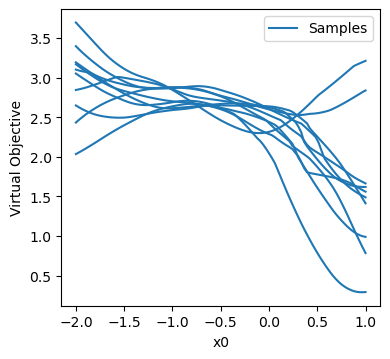

In [59]:
from xopt.generators.bayesian.bax.visualize import visualize_virtual_objective
model = optimizer.generator.train_model()

# for i in range(10):
visualize_virtual_objective(optimizer.generator, 
                            variable_names=['x0'],
                            reference_point={'x0':torch.tensor([0.]),
                                             'x1':torch.tensor([0.]),
                                            'x2':torch.tensor([0.]),
                                             'x3':torch.tensor([0.]),
                                             # 'x4':torch.tensor([0.]),
                                             # 'x5':torch.tensor([0.]),
                                             # 'x6':torch.tensor([0.]),
                                             # 'x7':torch.tensor([0.]),
                                             # 'x8':torch.tensor([0.]),
                                            },
                            n_grid=100,
                            n_samples=10,
                            show_samples=True,)
# visualize_virtual_objective(optimizer.generator, variable_names=['x0','x1'],reference_point={'x0':torch.tensor([0.]), 'x1':torch.tensor([0.])}, n_grid=10, n_samples=1000)

In [38]:
from emitopt.sampling import draw_product_kernel_post_paths
import copy

bounds = torch.from_numpy(vocs.bounds)

cpu_models = [copy.deepcopy(m).cpu() for m in model.models]

sample_funcs_list = []
for cpu_model in cpu_models:
    sample_funcs = draw_product_kernel_post_paths(cpu_model, n_samples=1)
    sample_funcs_list += [sample_funcs]
    
def wrapped_virtual_objective(x):
    x = torch.from_numpy(x)
    res = algo.evaluate_virtual_objective(sample_funcs_list, x.reshape(1,1,-1), bounds)
    return res[0,0].numpy()

c:\users\dylan\slac\emitopt\emitopt\sampling.py:117: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:1703.)
  Lnn = torch.cholesky(K.to_dense())


In [61]:
from scipy.optimize import differential_evolution, shgo, dual_annealing, minimize

opt_bounds = vocs.bounds.T
opt_bounds[algo.meas_dim] = [0,0]

start = time.time()
# res = differential_evolution(wrapped_virtual_objective, bounds=opt_bounds, polish=False, popsize=15, maxiter=5, seed=1)
# res = shgo(wrapped_virtual_objective, bounds=opt_bounds)
# res = dual_annealing(wrapped_virtual_objective, bounds=opt_bounds, seed=1)

from emitopt.algorithms import unif_random_sample_domain
x0 = unif_random_sample_domain(1, vocs.bounds.T).flatten().numpy()
res = minimize(wrapped_virtual_objective, x0, bounds=opt_bounds)

print(time.time() - start)
print(res.fun)

4.313516616821289
0.4597625056444456


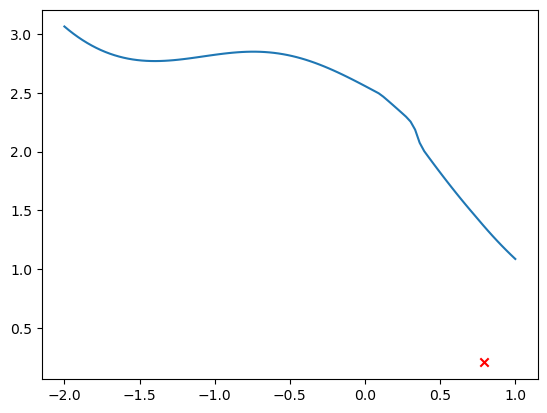

In [53]:
x = torch.linspace(-2, 1, 100)
x = x.reshape(100,1)
x = torch.cat((x, torch.zeros(100,3)), dim=1)
x = x.repeat(1, 1, 1)
vobj = algo.evaluate_virtual_objective(sample_funcs_list, x, bounds)

plt.plot(x[:,:,0].T, vobj.T, c='C0')
plt.scatter([res.x[0]], [res.fun], c='r', marker='x')

In [18]:
res

 message: Maximum number of iterations has been exceeded.
 success: False
     fun: 1.0510342086926652
       x: [ 1.461e-01  0.000e+00  2.310e-01  2.035e-01]
     nit: 1
    nfev: 600

In [19]:
opt_bounds[algo.meas_dim, :]

array([0., 0.])

In [20]:
(0.7063002)**2 * (1.00824715)**2 *(1-(0.01643308)**2)

0.5069853023720428

In [21]:
generator.algorithm.results["bss"][0,50,:,1]

tensor([ 0.8414, -0.1492, -0.1774,  0.7569,  2.6536,  5.5128,  9.3344],
       grad_fn=<SelectBackward0>)

In [22]:
generator.algorithm.results["emit"]

tensor([[[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1.

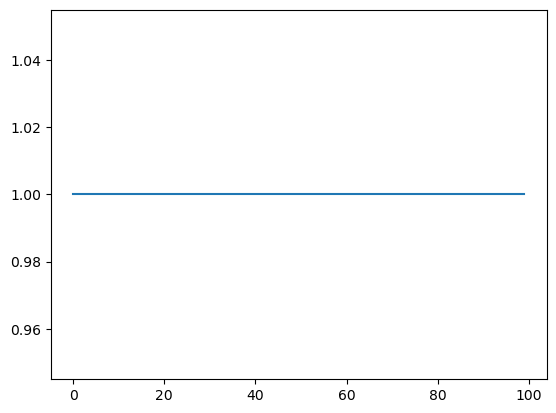

In [23]:
plt.plot(generator.algorithm.results["emit"][0,:,1])

In [24]:
# from emitopt.utils import x_tuning_to_dict, get_bax_optimum
# print(optimizer.generator.algorithm_results['x_tuning_best'])
# x_tuning_best = optimizer.generator.algorithm_results['x_tuning_best'].mean(dim=0)
# print(x_tuning_best)
# reference_point = get_bax_optimum(optimizer.generator)
# print(reference_point)
# target_point = x_tuning_to_dict(optimizer.generator, x_tuning = torch.tensor([[0]]))
# print(target_point)

In [25]:
from emitopt.visualize import plot_virtual_measurement_scan
fig, ax, best_q = plot_virtual_measurement_scan(optimizer, reference_point, n_samples=10)
ax[0].set_ylim(top=1)
ax[1].set_ylim(top=3, bottom=0.9)
ax[0].axhline(0, c='k')

NameError: name 'reference_point' is not defined

In [ ]:


from xopt.generators.bayesian.visualize import (
    _generate_input_mesh,
    _get_reference_point,
)

generator = optimizer.generator
variable_names = variable_names=['x0']
idx = -1
reference_point = {'x0':torch.tensor([0.]),
                                             'x1':torch.tensor([0.])}
show_samples = False
n_grid = 1
n_samples = 1
use_mean = False
kwargs = None


vocs, data = generator.vocs, generator.data
reference_point = _get_reference_point(reference_point, vocs, data, idx)
# define output and variable names
if variable_names is None:
    variable_names = vocs.variable_names
dim_x = len(variable_names)
if dim_x not in [1, 2]:
    raise ValueError(
        f"Visualization is only supported with respect to 1 or 2 variables, "
        f"not {dim_x}. Provide a compatible list of variable names to create "
        f"slice plots at higher dimensions."
    )

# validate variable names
invalid = [name not in getattr(vocs, "variable_names") for name in variable_names]
if any(invalid):
    invalid_names = [
        variable_names[i] for i in range(len(variable_names)) if invalid[i]
    ]
    raise ValueError(
        f"Variable names {invalid_names} are not in generator.vocs.variable_names."
    )

# validate reference point keys
invalid = [
    name not in getattr(vocs, "variable_names") for name in [*reference_point]
]
if any(invalid):
    invalid_names = [
        [*reference_point][i] for i in range(len([*reference_point])) if invalid[i]
    ]
    raise ValueError(
        f"reference_point contains keys {invalid_names}, "
        f"which are not in generator.vocs.variable_names."
    )

x = _generate_input_mesh(vocs, variable_names, reference_point, n_grid)

# verify model exists
if generator.model is None:
    raise ValueError(
        "The generator.model doesn't exist, try calling generator.train_model()."
    )

# subset bax observable models
bax_model_ids = [
    generator.vocs.output_names.index(name)
    for name in generator.algorithm.observable_names_ordered
]
bax_model = generator.model.subset_output(bax_model_ids)

# get virtual objective (sample) values
bounds = generator._get_optimization_bounds()
kwargs = kwargs if kwargs else {}


import time
start = time.time()

for i in range(100):
    objective_values = generator.algorithm.evaluate_virtual_objective(
        bax_model,
        x,
        bounds,
        tkwargs=generator._tkwargs,
        n_samples=n_samples,
        use_mean=use_mean,
        **kwargs
    )
time_elapsed = time.time() - start
print(time_elapsed)


In [ ]:
import numpy as np
x = np.array([[1,2],[3,4]])
np.sum(x.shape[:-2])

In [ ]:
np.tile(np.array([1,2,3]),0)

In [ ]:
x = np.array([1,2,3])
print(*x)